In [1]:
import sys
sys.path.insert(0, '../src')
sys.path.insert(0, '../')

import numpy as np
import torch
import matplotlib.pyplot as plt

from drawing import draw_window
from image import get_image_tensor, get_numpy_image
from shape import Window, Position
from roi_align import RoIAlignFeatureExtractor, CenterFeatureExtractor, RoIFeatureExtractor
from matcher import CnnMatcher, Window
from image import load_image
from feature_extractor import CNN, FeatureExtractor
from candidates import Candidates
from scorer import CosineSimilarityScorer
import cv2
import albumentations as A
import os
from PIL import Image
from IPython.display import Image as IpyImage

def create_gif(images, output_path, duration=200):
    pil_images = [Image.fromarray(image) for image in images]
    pil_images[0].save(output_path, save_all=True, append_images=pil_images[1:],
                       optimize=False, duration=duration, loop=0)
    
def rotate(
    img: np.ndarray,
    angle: float,
    interpolation: int = cv2.INTER_LINEAR,
    border_mode: int = cv2.BORDER_CONSTANT,
):
    height, width = img.shape[:2]
    # for images we use additional shifts of (0.5, 0.5) as otherwise
    # we get an ugly black border for 90deg rotations
    matrix = cv2.getRotationMatrix2D((width / 2 - 0.5, height / 2 - 0.5), angle, 1.0)

    return cv2.warpAffine(img, M=matrix, dsize=(width, height), flags=interpolation, borderMode=border_mode, borderValue=0)

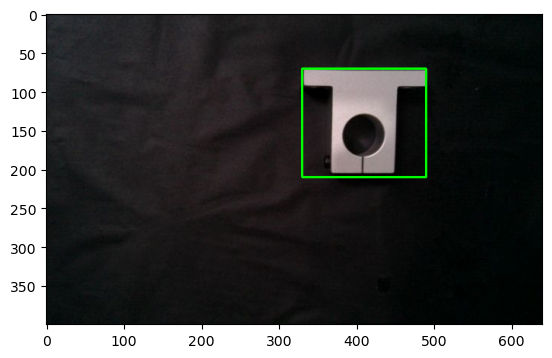

In [2]:
template_img = load_image('../data/template_1.jpg')
template_window = Window(410., 140., 160., 140., 0)

draw_img = draw_window(template_img, template_window)
plt.imshow(draw_img)

In [3]:
from feature_extractor import ReCNN
from shape.basic import Point
import torch.nn.functional as F

def test_rotation_equivarence(feature_extractor: FeatureExtractor, roi_feature_extractor: RoIFeatureExtractor):
    scales = [2, 4, 8, 16]

    img_h, img_w = template_img.shape[:2]
    rotation_center = Point((img_w - 1) * 0.5, (img_h - 1) * 0.5)
    all_rotated_images = []
    all_rotated_features = {s:[] for s in scales}

    for i in range(0, 360, 5):
        rotated_img = rotate(template_img.copy(), i)
        rotated_window = template_window.rotate(rotation_center, i)
        draw_img = draw_window(rotated_img, rotated_window)
        all_rotated_images.append(draw_img)

        for idx, scale in enumerate(scales):
            rotated_feature_map = feature_extractor(rotated_img)[idx]
            rotated_center = rotated_window.get_center(spatial_scale=1.0/scale)
            rotated_features = rotated_feature_map[:, :, rotated_center.cy, rotated_center.cx]
            rotated_features = roi_feature_extractor.extract(rotated_feature_map, rotated_window, spatial_scale=1.0/scale)
            all_rotated_features[scale].append(rotated_features)


    all_rotated_features = {s:torch.cat(f) for s, f in all_rotated_features.items()}

    for scale, features in all_rotated_features.items():
        normalized_features = F.normalize(features, dim=1)
        scores = torch.matmul(normalized_features, normalized_features.T)
        print(f'max score: {scores.max().item():.3f} min score: {scores.min().item():.3f} avg score: {scores.mean().item():.3f}')
        plt.imshow(scores, cmap='coolwarm', vmin=-1, vmax=1)
        plt.colorbar()
        plt.title(f'Rotation equivariance at scale {scale}')
        plt.show()

max score: 1.000 min score: 0.946 avg score: 0.984


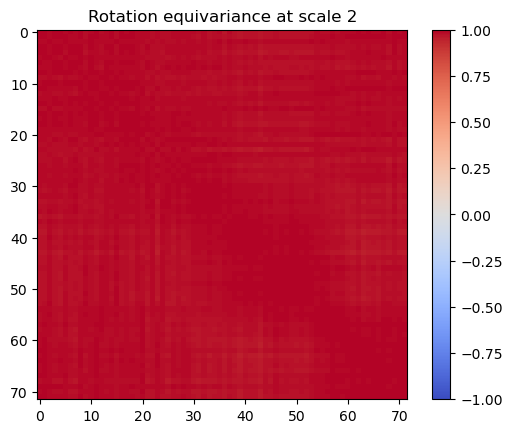

max score: 1.000 min score: -0.017 avg score: 0.682


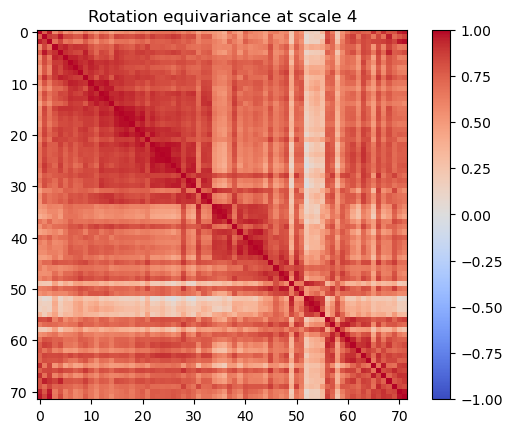

max score: 1.000 min score: -0.126 avg score: 0.595


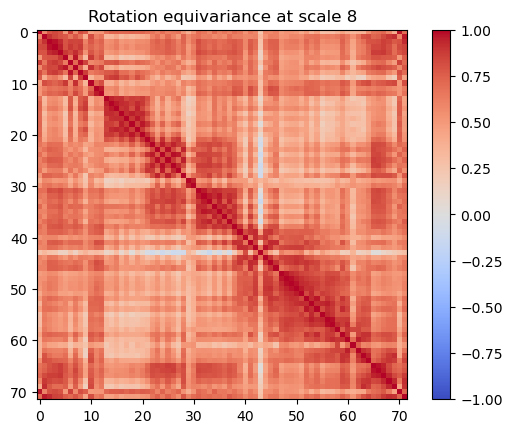

max score: 1.000 min score: -0.047 avg score: 0.489


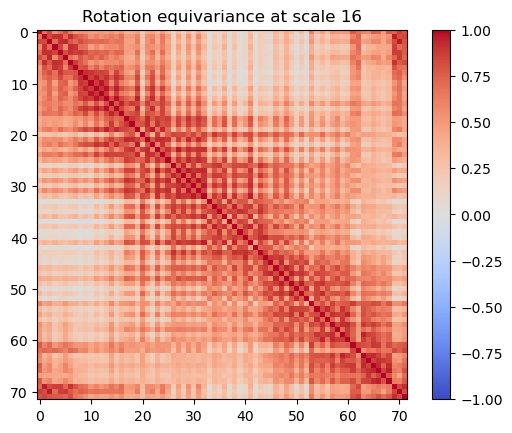

In [4]:
feature_extractor = CNN()
# feature_extractor = ReCNN()
roi_feature_extractor = CenterFeatureExtractor()
# roi_feature_extractor = RoIAlignFeatureExtractor(output_size=3, sampling_ratio=2)
test_rotation_equivarence(feature_extractor, roi_feature_extractor)

/opt/conda/lib/python3.7/site-packages/e2cnn/nn/modules/r2_conv/basisexpansion_singleblock.py:80: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/native/IndexingUtils.h:27.)
  full_mask[mask] = norms.to(torch.uint8)


max score: 1.000 min score: 0.998 avg score: 0.999


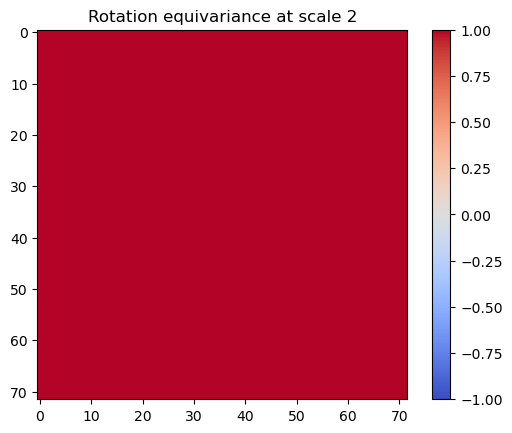

max score: 1.000 min score: 0.758 avg score: 0.908


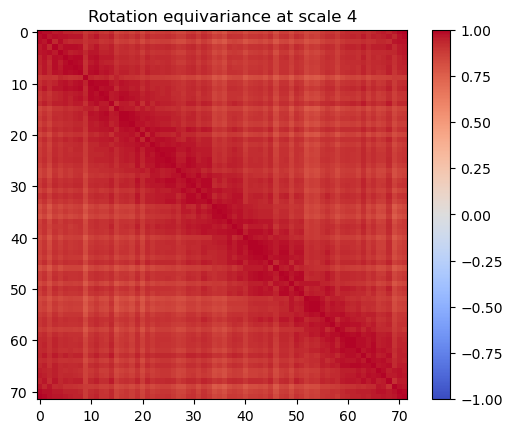

max score: 1.000 min score: 0.417 avg score: 0.667


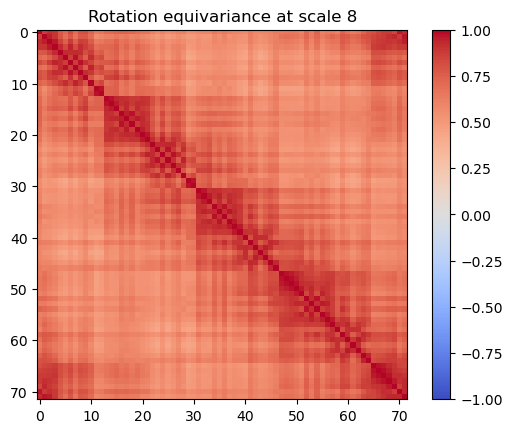

max score: 1.000 min score: 0.334 avg score: 0.566


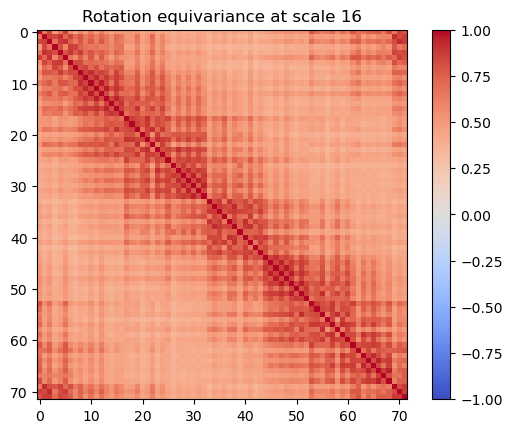

In [5]:
# feature_extractor = CNN()
feature_extractor = ReCNN()
roi_feature_extractor = CenterFeatureExtractor()
# roi_feature_extractor = RoIAlignFeatureExtractor(output_size=3, sampling_ratio=2)
test_rotation_equivarence(feature_extractor, roi_feature_extractor)

max score: 1.000 min score: 0.041 avg score: 0.541


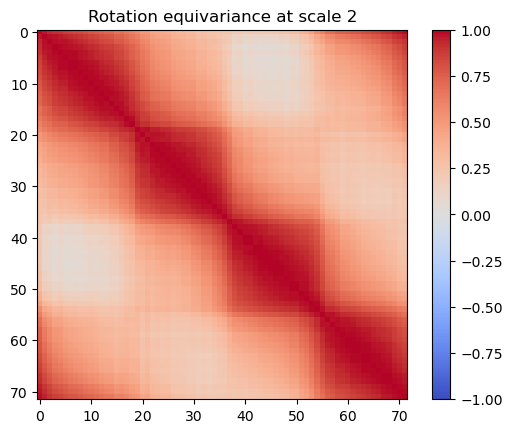

max score: 1.000 min score: 0.315 avg score: 0.635


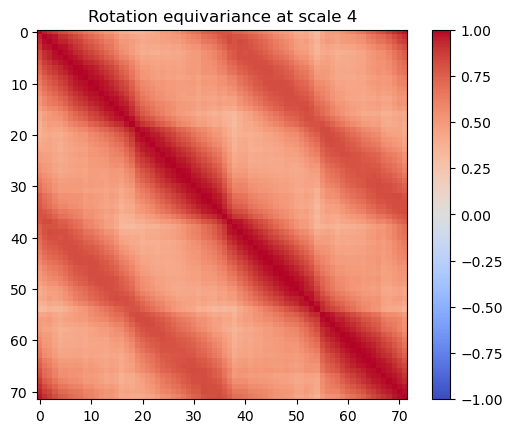

max score: 1.000 min score: 0.415 avg score: 0.619


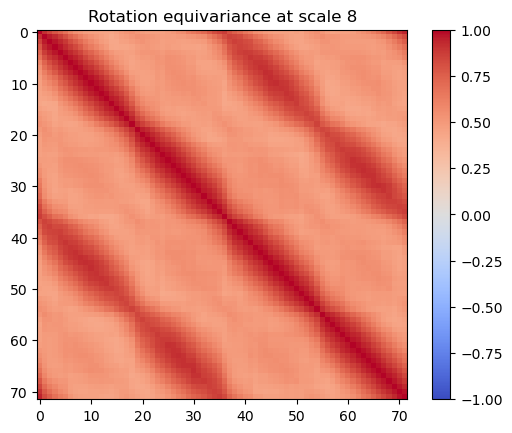

max score: 1.000 min score: 0.498 avg score: 0.697


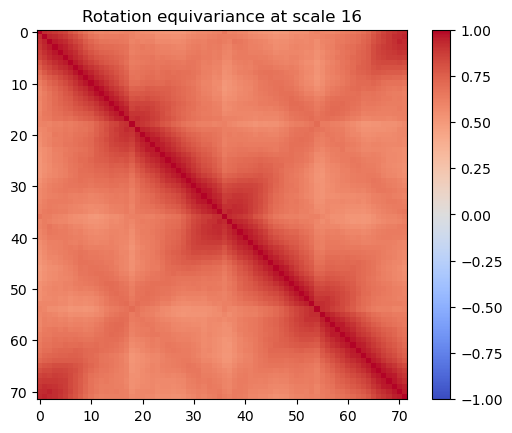

In [6]:
feature_extractor = CNN()
# feature_extractor = ReCNN()
# roi_feature_extractor = CenterFeatureExtractor()
roi_feature_extractor = RoIAlignFeatureExtractor(output_size=3, sampling_ratio=2)
test_rotation_equivarence(feature_extractor, roi_feature_extractor)

max score: 1.000 min score: 0.919 avg score: 0.960


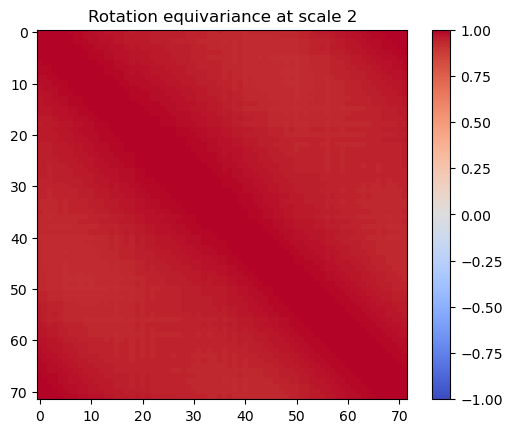

max score: 1.000 min score: 0.879 avg score: 0.920


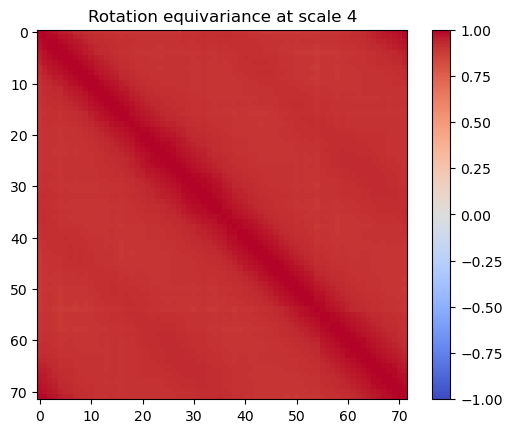

max score: 1.000 min score: 0.803 avg score: 0.858


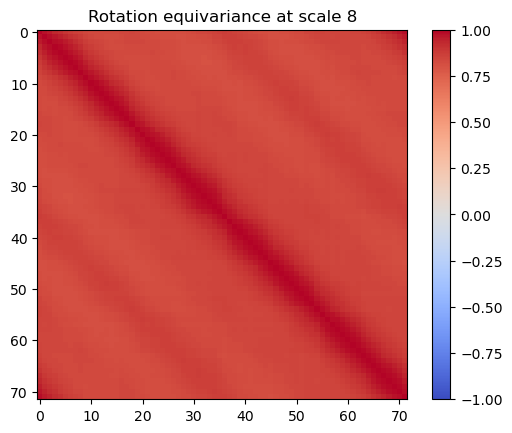

max score: 1.000 min score: 0.654 avg score: 0.759


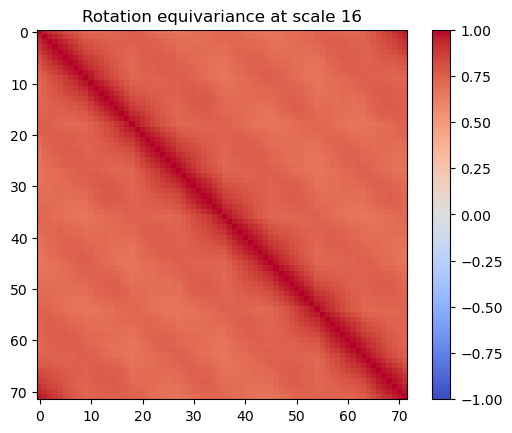

In [7]:
# feature_extractor = CNN()
feature_extractor = ReCNN()
# roi_feature_extractor = CenterFeatureExtractor()
roi_feature_extractor = RoIAlignFeatureExtractor(output_size=3, sampling_ratio=2)
test_rotation_equivarence(feature_extractor, roi_feature_extractor)

In [8]:
img_h, img_w = template_img.shape[:2]
rotation_center = Point((img_w - 1) * 0.5, (img_h - 1) * 0.5)
all_rotated_images = []
for i in range(0, 360, 5):
    rotated_img = rotate(template_img.copy(), i)
    rotated_window = template_window.rotate(rotation_center, i)
    draw_img = draw_window(rotated_img, rotated_window)
    all_rotated_images.append(draw_img)
    
save_path = '../data/rotated_image.gif'
if os.path.exists(save_path):
    os.remove(save_path)
create_gif(all_rotated_images, save_path)
IpyImage(url=save_path)